# Xception model with Keras

In [29]:
import pickle
import random
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import SGD
from keras.utils import plot_model
import scipy
import numpy as np
% matplotlib inline

## Create data generator using Keras

In [30]:
train_directory = r"C:\Study\SOM\images\training"
validation_directory = r"C:\Study\SOM\images\validation"
test_directory = r"C:\Study\SOM\images\test"

new_shape = (299,299,1)
train_datagen = ImageDataGenerator(
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
       validation_directory,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')


Found 115809 images belonging to 30 classes.
Found 6798 images belonging to 30 classes.


## See some examples

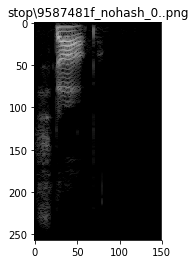

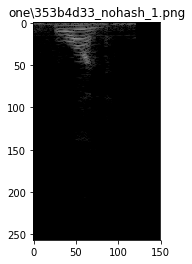

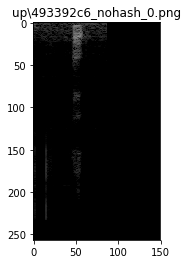

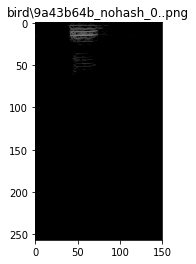

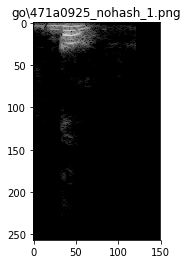

In [31]:
for i in range(5):
    fname = random.choice(train_generator.filenames)
    plt.imshow(mpimg.imread("{}\{}".format(train_directory, fname)))
    plt.title(fname)
    plt.show()

## Load Xception model

In [32]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


base_model = Xception(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(30, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Take a look at the model structure

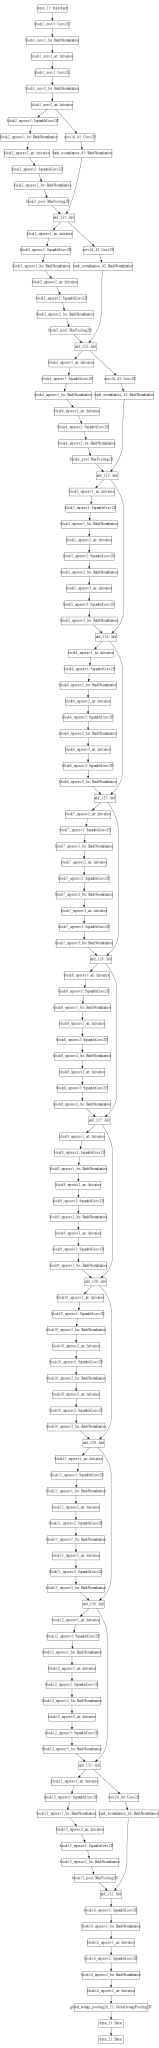

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')  

# plot_model(model, to_file='model.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train last fully-connected layer first

In [36]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator,
        steps_per_epoch=5000,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800)

model.save('my_model.h5')

Epoch 1/10
5000/5000 [==============================] - 1670s 334ms/step - loss: 2.3762 - acc: 0.3101 - val_loss: 3.7294 - val_acc: 0.0784
Epoch 2/10
5000/5000 [==============================] - 1666s 333ms/step - loss: 2.1050 - acc: 0.3841 - val_loss: 3.8551 - val_acc: 0.0817
Epoch 3/10
5000/5000 [==============================] - 1684s 337ms/step - loss: 1.9588 - acc: 0.4216 - val_loss: 3.9867 - val_acc: 0.0630
Epoch 4/10
5000/5000 [==============================] - 1657s 331ms/step - loss: 1.8380 - acc: 0.4529 - val_loss: 4.2462 - val_acc: 0.0688
Epoch 5/10
5000/5000 [==============================] - 1661s 332ms/step - loss: 1.7458 - acc: 0.4788 - val_loss: 4.6074 - val_acc: 0.0678
Epoch 6/10
5000/5000 [==============================] - 1656s 331ms/step - loss: 1.6569 - acc: 0.5020 - val_loss: 4.7114 - val_acc: 0.0689
Epoch 7/10
5000/5000 [==============================] - 1660s 332ms/step - loss: 1.5936 - acc: 0.5204 - val_loss: 5.1102 - val_acc: 0.0641
Epoch 8/10
5000/5000 [=====

## Train last 2 blocks of Xception model

In [37]:
# we chose to train the top 2 Xception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:115]:
    layer.trainable = False
for layer in model.layers[115:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_generator,
        steps_per_epoch=5000,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800)

model.save('my_model_1.h5')

Epoch 1/10
5000/5000 [==============================] - 1864s 373ms/step - loss: 1.0191 - acc: 0.6900 - val_loss: 6.4997 - val_acc: 0.0606
Epoch 2/10
4186/5000 [========================>.....] - ETA: 4:22 - loss: 0.8769 - acc: 0.7331

KeyboardInterrupt: 